# Apply explainability techniques to the Best model

## 1. Feature Importance

Feature importance methods help you understand which features contribute the most to the predictions of your model.

### 1.1 Permutation Importance:

### 1.2 SHAP Values (SHapley Additive exPlanations):

## 2. Partial Dependence Plots (PDP)

## 3. Individual Conditional Expectation (ICE) Plots

## 4. Local Interpretable Model-agnostic Explanations (LIME)

## 5. Integrated Gradients

Integrated Gradients is a technique specific to neural networks that attributes the change in the prediction to the change in the feature values. It’s especially useful for models where gradients can be computed, providing a measure of feature importance by integrating the gradients along the path from a baseline input to the actual input.

## 6. Saliency Maps

Saliency maps are used primarily in the context of neural networks to show the importance of features by taking the gradient of the output with respect to the input. This technique is often visualized as heatmaps in the case of image data, but it can also be adapted for tabular data.


### Import Libraries


In [27]:
# downgrade sklearn to 1.3.2
#! pip install scikit-learn==1.3.2 shap lime
#! pip install shap
#! pip install lime

import os
import numpy as np
import matplotlib.pyplot as plt
import shap
import seaborn as sns
import joblib
import pandas as pd

from sklearn.inspection import permutation_importance

plt.style.use("seaborn-v0_8-paper")

sns.set_theme(context="paper", font_scale=1)

### Load Data and Model


In [31]:
# HYERPARAMETERS
SEED = 42
INTERVAL = 1

BALANCING_TYPE = "none"
RESULT_NAME = f"results_ensemble_v4_best_features_{BALANCING_TYPE}.csv"
CM_NAME = f"cm_ensemble_v4_best_features_{BALANCING_TYPE}.csv"
mod = "../../models/MLP_rollercoaster_none.joblib"

# set the paths
BASE_DIR = "../../dataset/"

# features
FEATURES_BASE = "../../features/"
FEATURES = FEATURES_BASE + "raw/"
# FEATURES = FEATURES_BASE + 'balanced/posteriori/'


# Models
MODELS_PATH = "../../models/"
MODELS_RESULTS = MODELS_PATH + "results/"
BEST_MODEL = MODELS_PATH + f"MLP_ensemble2_{BALANCING_TYPE}.joblib"
# report
PAPER = "../../paper/"
IMAGES_PATH = PAPER + "images/"


# -----------------------------------------Constants-----------------------------------------
full_data_dict_keys = ["artifacts", "extrahls", "murmurs", "normals", "extrastoles"]
interval = INTERVAL  # You need to define INTERVAL somewhere
sample_rates = [4000]
num_feats = {
    "30 MFCC": "28mfcc",
    "12  Chroma": "12chroma",
    "70 CQT": "0cqt",
    "40 RMS": "0rms",
    "40 Zero Crossing Rates": "1zcr",
    "40 Spectral Centroid": "0sc",
    "60 Spectral Bandwidth": "0sb",
    "40 Spectral Rolloff": "0sr",
}

COMPLETE_DATA_PRIOR_CORR_NAME = (
    f"full_data_filtered_{INTERVAL}s_4000hz_"
    + "_".join(numvalue for _, numvalue in num_feats.items())
    + ".npy"
)
# load the data
full_data = np.load(FEATURES + COMPLETE_DATA_PRIOR_CORR_NAME, allow_pickle=True).item()
n_cols = full_data["train"]["X"].shape[1]

model = joblib.load(BEST_MODEL)

X_train = full_data["train"]["X"]
y_train = full_data["train"]["y"]
X_test = full_data["test"]["X"]
y_test = full_data["test"]["y"]

features_name = full_data["features"]

### 1.1 Permutation Importance:

Measures the importance of features by evaluating the increase in the model's prediction error after permuting the feature values.

#### How it functions:

1. Train the model on the original dataset and calculate the model's performance metric (F1 score macro).
2. For each feature, shuffle its values and calculate the performance metric again.
3. The difference between the original metric and the shuffled metric is the permutation importance of the feature.
4. Repeat the process multiple times to get a more stable estimate of the importance.
5. The mean importance and standard deviation across repetitions are calculated for each feature.

#### Interpretation of the Permutation Importance Graph

##### Top Features:

1. MFCC_4: This feature has the highest permutation importance, indicating it is the most influential feature for the model's predictions. The importance mean is around 0.25.
2. MFCC_3 and MFCC_6: These features are also highly important, with importance means slightly above 0.20. They follow MFCC_4 in terms of importance.

##### Middle-Ranked Features:

3. MFCC_5, MFCC_7, MFCC_10, MFCC_9, and others: These features have moderate importance with means ranging from approximately 0.05 to 0.15.  
   This indicates that these features contribute significantly to the model's predictions but are less critical than the top features.

##### Least Important Features:

4. Chroma 3, Chroma 2, Chroma 12, Chroma 4, Chroma 1, Chroma 11, and others: These features have very low or near-zero permutation importance means.
   This suggests that the model's predictions are not significantly affected by these features, indicating they might be redundant or not useful for the current task.

##### Standard Deviation (Error Bars):

The error bars (black lines) on top of the bars represent the standard deviation of the permutation importance across multiple repetitions.
Features with larger error bars have more variability in their importance, suggesting that their contribution to the model's predictions may be less stable.

#### Summary

The MFCC features (especially MFCC_4, MFCC_3, and MFCC_6) are crucial for the model's predictions. These features should be prioritized in feature engineering and analysis.
The Chroma features, particularly those with very low permutation importance, may be less useful for this model. You might consider whether these features add value or if the model could be simplified by removing them.
The variability in importance suggests some features are more consistently influential than others. For instance, MFCC_4 and MFCC_3 have relatively smaller error bars compared to some of the middle-ranked features, indicating a stable contribution to the model.

##### Next Steps

1. Feature Engineering: Focus on the most important features (e.g., MFCC_4, MFCC_3, MFCC_6) to improve model performance.
2. Feature Selection: Consider removing or further analyzing the least important features (e.g., low-importance Chroma features) to simplify the model and potentially reduce overfitting.

3. Model Stability: Investigate the features with large error bars to understand the variability in their importance and determine if more robust features can be created.


In [ ]:
result = permutation_importance(
    model, X_test, y_test, n_repeats=500, random_state=42, n_jobs=-1, scoring="f1_macro"
)

# Get feature importance
importance_means = result.importances_mean
importance_std = result.importances_std

# Sort features by importance
indices = np.argsort(importance_means)[::-1]
sorted_features = [features_name[i] for i in indices]

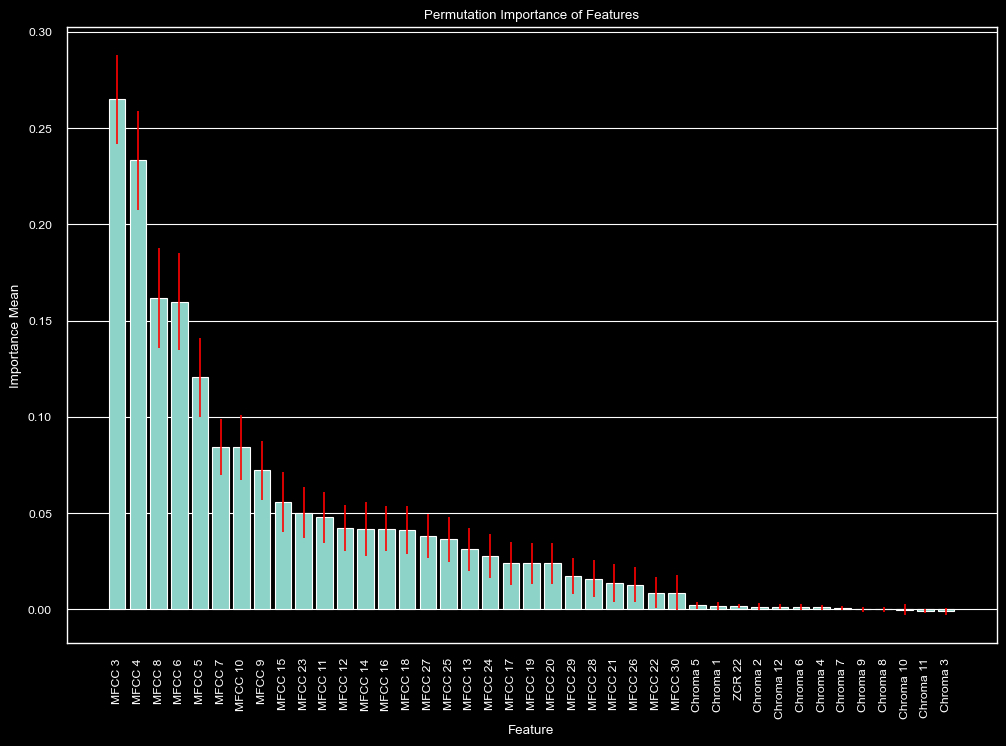

In [14]:
# Plot feature importance
plt.figure(figsize=(12, 8))
plt.style.use("dark_background")

plt.title("Permutation Importance of Features")
plt.bar(
    range(X_test.shape[1]),
    importance_means[indices],
    yerr=importance_std[indices],
    align="center",
    error_kw={
        "ecolor": "red",
        "capsize": 5,
    },  # 'capsize' is optional, it adds caps at the ends of error bars
)

plt.xticks(range(X_test.shape[1]), sorted_features, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance Mean")
plt.grid(visible=True,axis='y')
plt.grid(visible=False, axis="x")

plt.show()

### 1.2 SHAP Values (SHapley Additive exPlanations):

SHAP values provide a unified measure of feature importance, considering both individual and interaction effects. It’s based on cooperative game theory and offers a consistent way to interpret feature contributions.

#### Interpreting the SHAP Interaction Summary Plot

1. **Axes**:

   - **X-axis (SHAP interaction value)**: This represents the SHAP interaction value for each feature pair. It indicates how much each pair of features influences the model's prediction together.
   - **Y-axis (Features)**: The features are listed on the y-axis, and the interaction values are plotted for each pair of features.

2. **Colors**:

   - The colors represent the value of the interacting feature. For example, in the interaction between MFCC 6 and MFCC 3, the color gradient shows how the value of MFCC 3 affects the interaction.

3. **Points**:
   - Each dot represents an instance (a data point) in the test set.
   - The position of the dots along the x-axis shows the interaction effect on the model's output.

#### Detailed Interpretation

1. **MFCC 4**:

   - The interaction plot for MFCC 4 shows its interactions with other MFCC features.
   - When MFCC 4 interacts with other features, the SHAP interaction values vary significantly, suggesting that MFCC 4 has a strong interaction effect on the model's prediction.

2. **MFCC 3**:

   - The interaction plot for MFCC 3 shows distinct patterns with MFCC 6, MFCC 5, MFCC 7, and MFCC 4.
   - There is a notable interaction effect, especially when MFCC 3 values are higher (color transitioning to red).

3. **MFCC 6**:

   - MFCC 6 interacts significantly with MFCC 3 and MFCC 7.
   - The plot indicates that when MFCC 6 values are higher, the interaction effect is stronger.

4. **Symmetry and Patterns**:
   - The diagonal plots (like MFCC 6 vs MFCC 6) are symmetrical and show the direct effect of a feature on itself, which should ideally be neutral or less pronounced.
   - Off-diagonal plots (like MFCC 6 vs MFCC 3) show the interaction effects between different features.

#### Key Takeaways

- **Interaction Strength**: The width and spread of the points along the x-axis indicate the strength of the interaction effect. Wider spreads suggest stronger interactions.
- **Feature Importance**: Features like MFCC 4, MFCC 3, and MFCC 6 show strong interaction effects, indicating their importance not just individually but also in combination with other features.
- **Model Insights**: By examining how features interact, you can gain insights into complex dependencies and relationships that the model has learned. This can inform feature engineering and model refinement.

#### Next Steps

1. **Focus on Key Interactions**: Pay attention to the feature pairs with the strongest interaction effects, as these are critical to your model’s performance.
2. **Feature Engineering**: Consider creating new features based on these interactions or refining the existing ones to capture these dependencies more effectively.
3. **Model Improvement**: Use the insights from the SHAP interaction values to potentially simplify the model by focusing on the most impactful features and interactions.


In [18]:
import warnings
import joblib

# Suppress UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

# Use SHAP to explain the model's predictions
X_train_df = pd.DataFrame(X_train, columns=features_name)
X_test_df = pd.DataFrame(X_test, columns=features_name)
explainer = shap.Explainer(model.predict_proba, X_train_df)

if os.path.exists(MODELS_RESULTS + "shap_values.joblib"):
    shap_values = joblib.load(MODELS_RESULTS + "shap_values.joblib")
else:
    shap_values = explainer.shap_values(X_test_df)
    joblib.dump(shap_values, MODELS_RESULTS + "shap_values.joblib")

if os.path.exists(MODELS_RESULTS + "shap_values_explainer.joblib"):
    shap_values_explainer = joblib.load(MODELS_RESULTS + "shap_values_explainer.joblib")
else:
    shap_values_explainer = explainer(X_test_df)
    joblib.dump(shap_values_explainer, MODELS_RESULTS + "shap_values_explainer.joblib")

[4.]
4.0


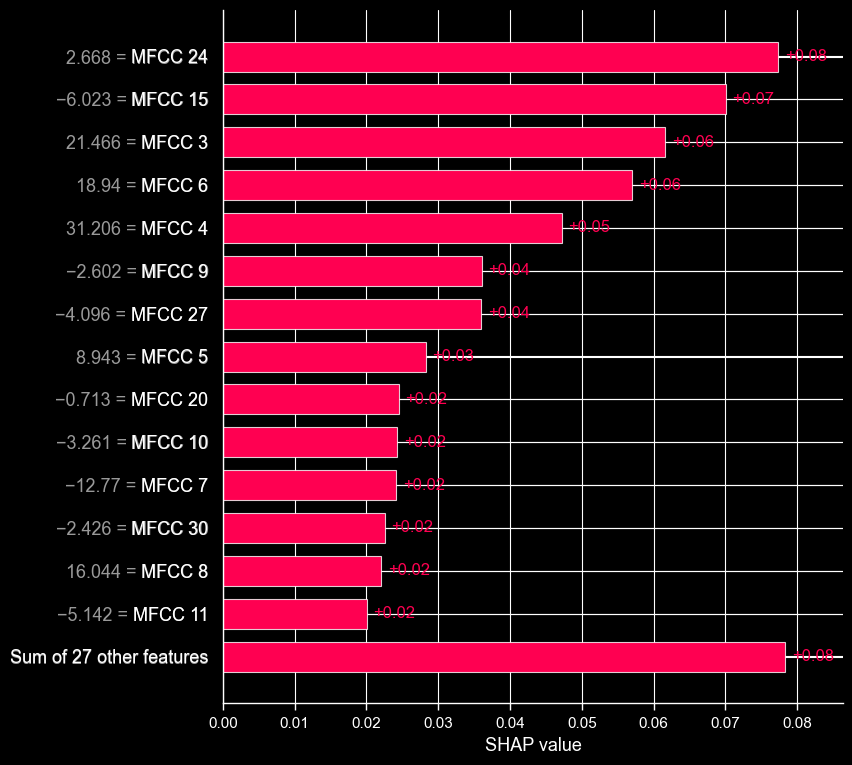

In [61]:
index = 614
print(model.predict(X_test[index, :].reshape(1, -1)))


print(y_test[index])
plt.style.use("dark_background")


shap.plots.bar(shap_values_explainer[index, :, 4], max_display=15)

| Name        | Label |
| ----------- | ----- |
| artifacts   | 0     |
| extrahls    | 1     |
| murmurs     | 2     |
| normals     | 3     |
| extrastoles | 4     |

In [47]:
COMPLETE_DATA_PRIOR_CORR_NAME = (
    f"full_data_filtered_{INTERVAL}s_4000hz_"
    + "_".join(numvalue for _, numvalue in num_feats.items())
    + "_FILENAME.npy"
)
filenames = full_data["test"]["filename"]

import os

# Load the data
full_data = np.load(FEATURES + COMPLETE_DATA_PRIOR_CORR_NAME, allow_pickle=True).item()
for clas in np.unique(y_test):
    mask_1 = y_test == clas
    X_test_clas = X_test[mask_1]
    y_test_clas = y_test[mask_1]
    filenames_clas = filenames[mask_1]

    # Keep track of the original indices
    original_indices_clas = np.where(mask_1)[0]
    pred_proba = model.predict_proba(X_test_clas)
    max_prob = np.max(pred_proba, axis=1)
    pred = np.argmax(pred_proba, axis=1)

    mask = pred == y_test_clas
    max_prob = max_prob[mask]
    filenames_clas = filenames_clas[mask]
    original_indices_clas = original_indices_clas[mask]

    best_prediction_index = np.argmax(max_prob)
    best_prob = max_prob[best_prediction_index]
    best_filename = filenames_clas[best_prediction_index]
    original_index = original_indices_clas[best_prediction_index]

    print(f"\nClass: {clas}")
    print(f"Best sample index in X_test: {original_index}")
    print(f"Best prob: {best_prob}")
    print(f"Filename: {best_filename}")

    BASE_DIR = "../../dataset/"
    # dirs = os.listdir(BASE_DIR + "normals_4000/")
    # filename = dirs[best_prediction_index]
    # print("Filename: ", filename)


Class: 0.0
Best sample index in X_test: 104
Best prob: 1.0
Filename: 82.0

Class: 1.0
Best sample index in X_test: 572
Best prob: 0.7912938917730865
Filename: 4.0

Class: 2.0
Best sample index in X_test: 249
Best prob: 0.9949990187766675
Filename: 97.0

Class: 3.0
Best sample index in X_test: 430
Best prob: 0.9999934022417669
Filename: 281.0

Class: 4.0
Best sample index in X_test: 614
Best prob: 0.6899305700164755
Filename: 35.0


In [42]:
original_indices_clas

array([  9,  63,  72,  79,  84, 132, 154, 159, 177, 179, 207, 229, 238,
       246, 277, 287, 312, 313, 359, 367, 382, 399, 448, 458, 463, 494,
       501, 504, 506, 545, 558, 571, 583, 614, 634, 664, 676, 681, 715,
       718, 736, 745, 757, 766, 829, 848, 860, 871, 883, 907, 916, 922,
       965, 973], dtype=int64)

In [35]:
classes = {0: "artifact", 1: "extrahls", 2: "murmur", 3: "normal", 4: "extrastole"}


if os.path.exists(MODELS_RESULTS + "permutation_importance_per_class.csv"):
    result_df = pd.read_csv(MODELS_RESULTS + "permutation_importance_per_class.csv")
else:
    result_df = pd.DataFrame(columns= ["Feature","Mean","Std","Class"])

    for label, class_name in classes.items():
        X_train_class = X_train[y_train == label]
        y_train_class = y_train[y_train == label]
        result = permutation_importance(
            model,
            X_train_class,
            y_train_class,
            n_repeats=y_train_class.shape[0],
            random_state=42,
            n_jobs=-1,
            scoring="f1_macro",
        )
        print(result.keys())
        mean = result["importances_mean"]
        std = result["importances_std"]
        group = np.concatenate(
            (np.array(features_name).reshape(-1,1), mean.reshape(-1, 1)),
            axis=1,
        )
        group = np.concatenate(
            (group,std.reshape(-1, 1)),
            axis=1,
        )
        group = np.concatenate(
            (group, np.array([class_name] * mean.shape[0]).reshape(-1, 1)),
            axis=1,
        )
        result_df = pd.concat([result_df, pd.DataFrame(group, columns=result_df.columns)], axis=0)
    result_df.to_csv(
        MODELS_RESULTS + "permutation_importance_per_class.csv", index=False
    )

/tmp/ipykernel_62475/1123252388.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.sort_values(by="Mean", ascending=False, inplace=True)


<Figure size 5000x1000 with 0 Axes>

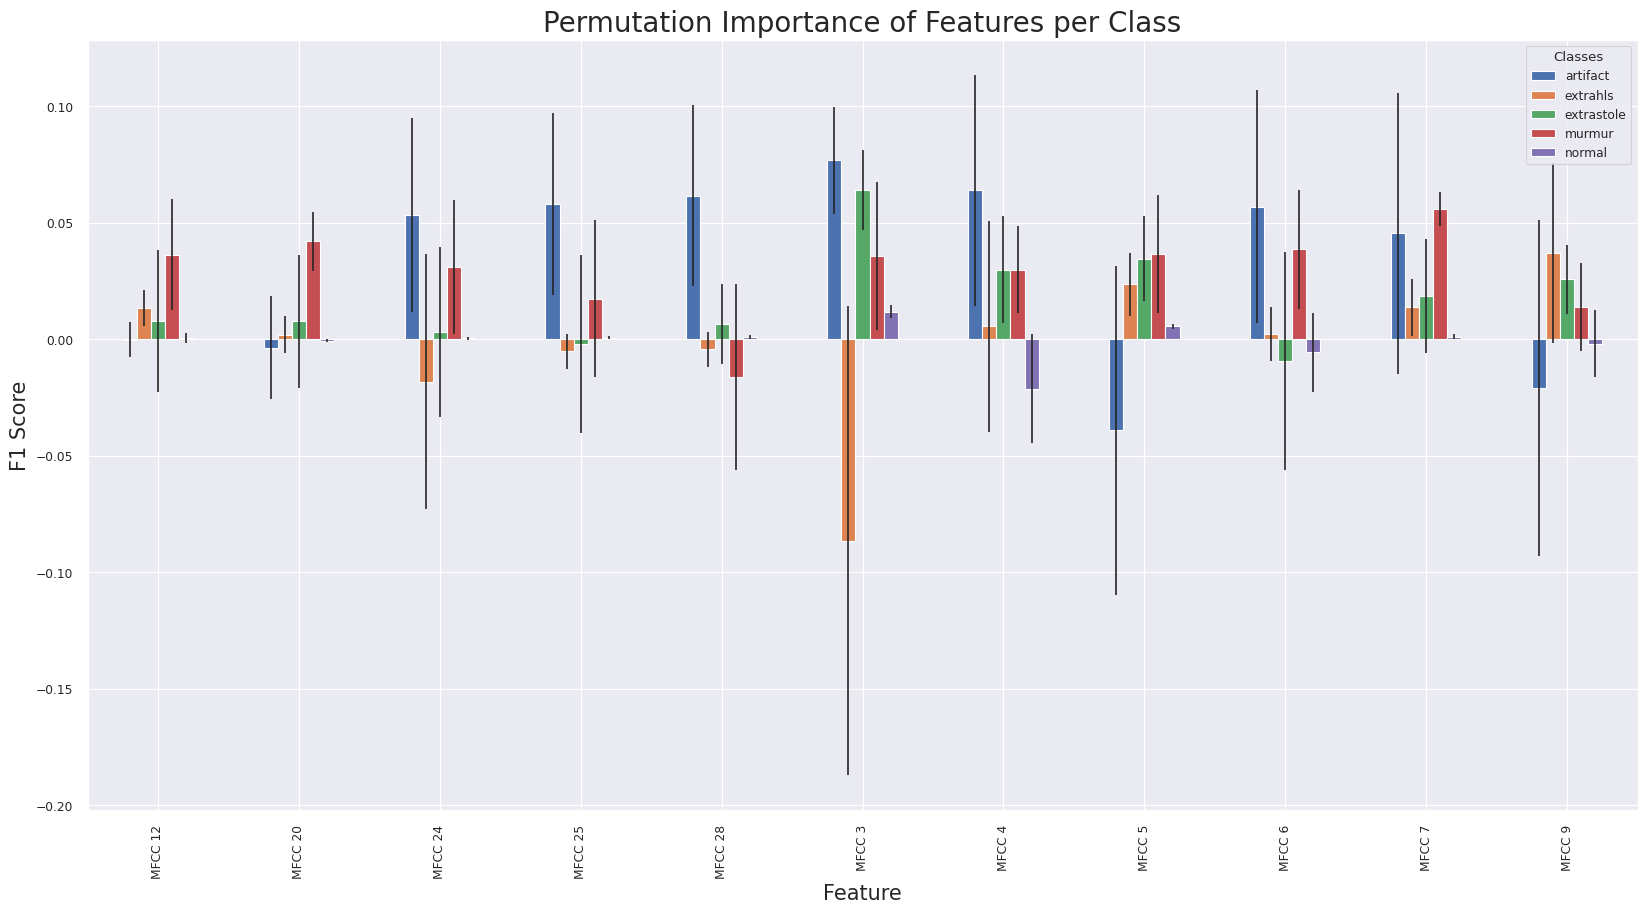

In [41]:
tmp= result_df[["Feature","Mean"]]

tmp.sort_values(by="Mean", ascending=False, inplace=True)
top_features = tmp.head(15)

# Plot the top 10 features
top_df = result_df[result_df["Feature"].isin(top_features["Feature"])]

# Assuming 'result_df' is your DataFrame
plt.figure(figsize=(50, 10))
top_df.pivot(index="Feature", columns="Class", values="Mean").plot(
    kind="bar",
    yerr=result_df.pivot(index="Feature", columns="Class", values="Std"),
    rot=90,
    figsize=(20, 10),
)
plt.xlabel("Feature", fontsize=15)
plt.ylabel("F1 Score", fontsize=15)
plt.title("Permutation Importance of Features per Class", fontsize=20)
plt.legend(title="Classes")
plt.show()